<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/TheoreticalMigrationMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from scipy.optimize import curve_fit, minimize
from scipy.special import expit, logit

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
pd.options.display.float_format = '{:.4f}'.format #Change display format in DataFrame table
warnings.filterwarnings('ignore') #Disable warning

In [2]:
# Define plot matrix function
def plotMatrix(data, plotName, format = None):
  plt.figure(figsize = (10, 6))
  plt.title(f'{plotName}')
  if format is None:
    formatType = '.4f'
    cmapType = 'RdYlGn'
  else:
    formatType = '.2%'
    cmapType = 'RdYlGn_r'
  ax = sns.heatmap(
      data,
      annot = True,
      fmt = formatType,
      xticklabels = True,
      yticklabels = True,
      cmap = cmapType,
      cbar = False
  )
  ax.xaxis.tick_top() # x-axis on top
  ax.xaxis.set_label_position('top')
  return plt.show()

In [3]:
# Define plot curve function
def plotCurve(data, x, y, xLabel, yLabel, title, function):
  plt.figure(figsize = (10, 6))
  plt.scatter(
      x = data[x],
      y = data[y]
  )
  if function == 'Exponential':
    plt.plot(
        data[x],
        [ExpoDecayFunction(n, *popt) for n in abs(data[x])],
        linewidth = 1.5,
        color = 'orange',
        linestyle = '--',
        marker = 'o'
    )
  else:
    plt.plot(
        data[x],
        [QuadraticFunction(n, *popt) for n in abs(data[x])],
        linewidth = 1.5,
        color = 'orange',
        linestyle = '--',
        marker = 'o'
    )
  plt.xticks(
      data[x]
  )
  plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
  plt.title(title)
  plt.xlabel(xLabel)
  plt.ylabel(yLabel)
  return plt.show()

In [4]:
# Define plot rate function
def plotRate(data, x, h, y, xLabel, y1Label, y2Label, title):
  plt.figure(figsize = (10, 6))
  plt.bar(
      x = data[x],
      height = data[h]
  )
  plt.xlabel(xLabel)
  plt.ylabel(y1Label)
  plt.twinx()
  plt.xticks(
      data[x]
  )
  plt.plot(
      data[x],
      data[y],
      linewidth = 1.5,
      color = 'orange',
      linestyle = '--',
      marker = 'o'
  )
  plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
  plt.title(title)
  plt.ylabel(y2Label)
  return plt.show()

In [5]:
# Import data
RAW_COUNT = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/SmoothingRawMatrix.csv'
)

# Show table
RAW_COUNT.head(5)

,Rating,Rating12,Count
0,1,1,1075
1,1,2,574
2,1,3,572
3,1,4,607
4,1,5,600


# Raw Migrtation Matrix
A migration matrix captures the movement expected in given performance window e.g., 12-Month. Either the rating grade or score band of any customers are determining the probability of moving from an initial grade to another over the performance window based on historical data migrations.

## Limitation of Raw Movement
The raw migration matrix (observed by historical data) might contain inconsistencies and concentration within particular risk segment. Below is an example:

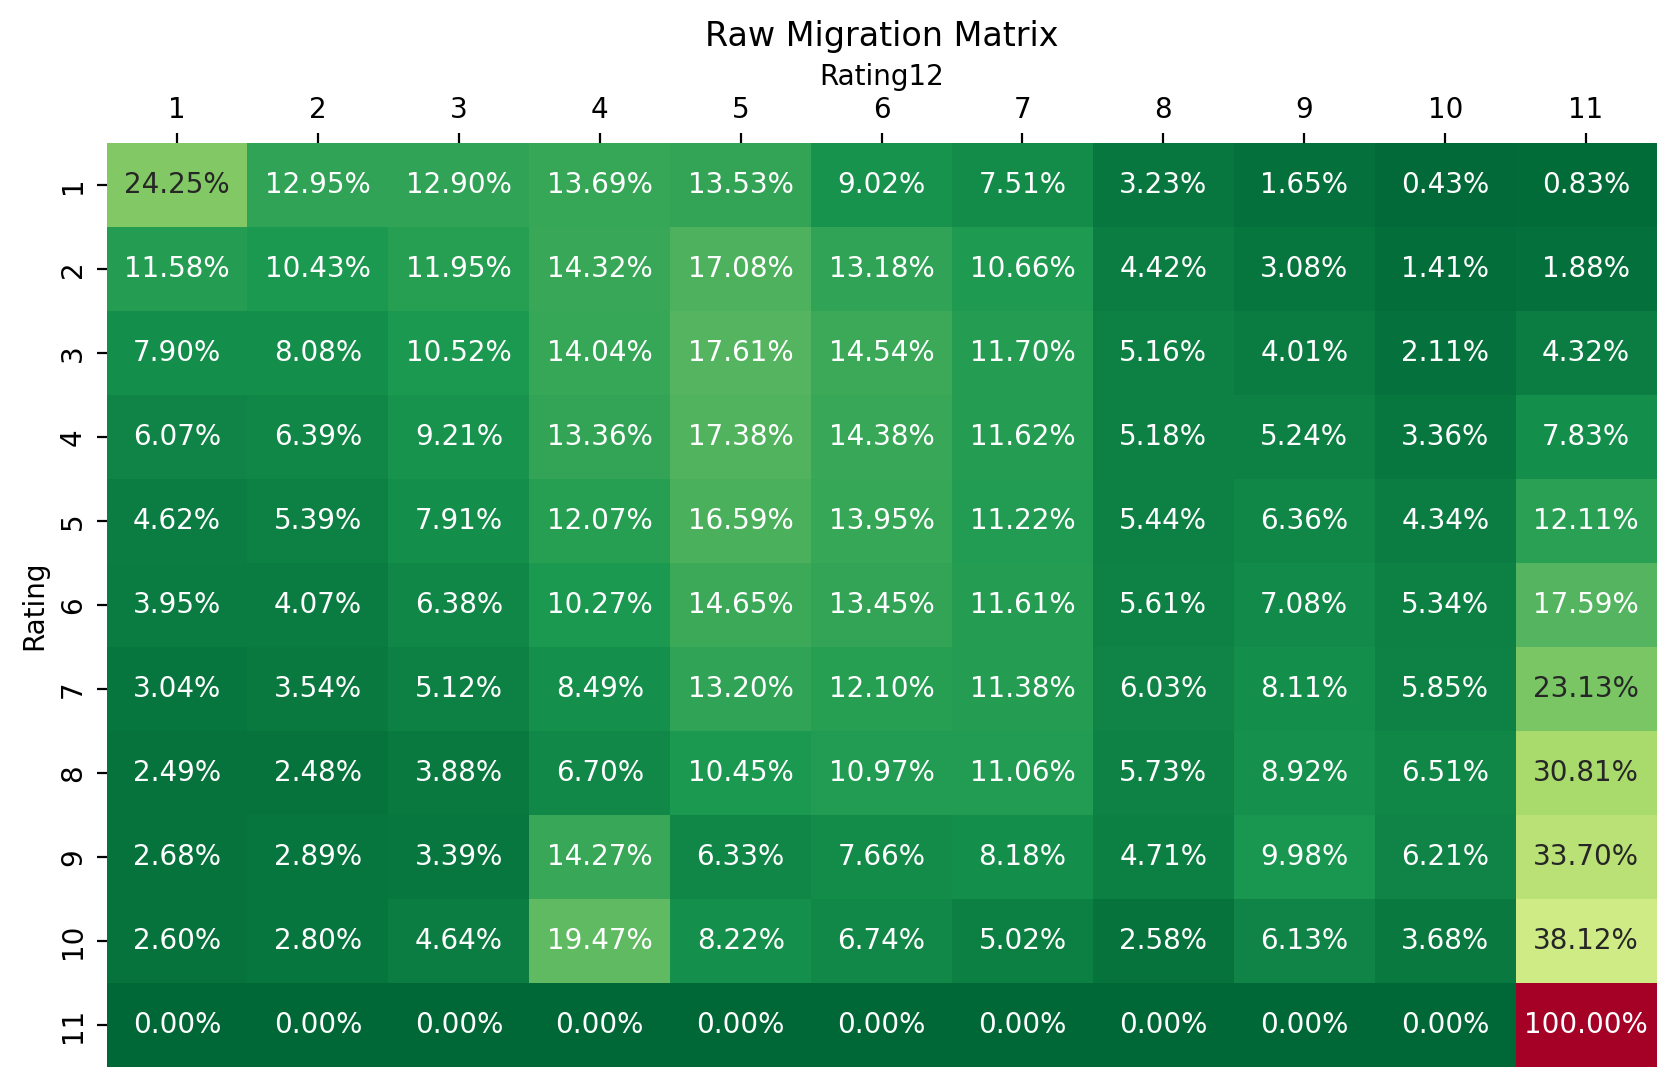

In [6]:
# Pivot to migration matrix
RawMatrix = pd.pivot_table(
    RAW_COUNT,
    values = 'Count',
    index = ['Rating'],
    columns = ['Rating12'],
    aggfunc = sum
).fillna(0)

# Migration rate
RawMatrix = RawMatrix.div(
    RawMatrix.sum(axis = 1),
    axis = 0
)

# Show matrix
plotMatrix(RawMatrix, 'Raw Migration Matrix', 'Percent')

# Smoothing the raw migration matrix to Theoretical Migration Matrix (TMM)
A smoothing methodology aims to remove any inconsistencies of raw migration matrix and produces a Theoretical Migration Matrix (TTM). To compile with one of the migration matrix assumptions that the diagonally dominant.

In [7]:
# Migration rate in long format
RAW_COUNT['MigrationRate'] = RAW_COUNT['Count'] / RAW_COUNT.groupby('Rating')['Count'].transform('sum')

# Selection only non-default observation
DEFAULT_INDEX = RAW_COUNT['Rating'].max() #Default at max rating
UpDown = RAW_COUNT[
    (RAW_COUNT['Rating'] != DEFAULT_INDEX) & (RAW_COUNT['Rating12'] != DEFAULT_INDEX)
]

# Notch change
UpDown['Notch'] = UpDown['Rating'] - UpDown['Rating12']

'''
Notch change:
- Positive: Upgrade e.g., 3 means rating 8 up-to rating 5
- Negative: Downgrade e.g., -2 means rating 1 down-to rating 3
- Zero: Stay rate (diagonal in migration matrix)
'''

# Show table
UpDown.head(5)

,Rating,Rating12,Count,MigrationRate,Notch
0,1,1,1075,0.2425,0
1,1,2,574,0.1295,-1
2,1,3,572,0.1290,-2
3,1,4,607,0.1369,-3
4,1,5,600,0.1353,-4


In [8]:
# Count non-default observation
UpDown['TotalCount'] = UpDown.groupby('Rating')['Count'].transform('sum')

# Selection for calculation
'''
Selection:
1. Median notch change either upgrade or downgrade e.g.,
   Total rating is 11, median is 6. Thus, it can upgrade or downgrade 5 notch
2. Notch must have migration rate e.g., 0 Notch will be excluded
'''
MEDIAN_RATING = UpDown['Rating'].median() #Calculate median rating
UpDown = UpDown[
    (abs(UpDown['Notch']) < MEDIAN_RATING) & (UpDown['Notch'] != 0)
]

# Show table
UpDown.head(5)

,Rating,Rating12,Count,MigrationRate,Notch,TotalCount
1,1,2,574,0.1295,-1,4396
2,1,3,572,0.1290,-2,4396
3,1,4,607,0.1369,-3,4396
4,1,5,600,0.1353,-4,4396
5,1,6,400,0.0902,-5,4396


In [9]:
# Weighted average for upgrade and downgrade
UpDownWeighted = UpDown.groupby(
    ['Notch'],
    as_index = False
).apply(
    lambda x: pd.Series(
        {
            'Rate': np.average(
                x['MigrationRate'],
                weights = x['TotalCount']
            )
        }
    )
)

# Show table
UpDownWeighted

,Notch,Rate
0,-5,0.0564
1,-4,0.0747
2,-3,0.0999
3,-2,0.1185
4,-1,0.1283
5,1,0.1030
6,2,0.0820
7,3,0.0663
8,4,0.0524
9,5,0.0595


# The optimal function form
## Function form for notches on upgrades or downgrades
The function form model to estimate number of notches migration. The notches migration are weighted by number of observation to ensure optimiser can provide minimum error as closely as possible. The exponential function has been selected for fitting purpose and has been shown below:
\begin{align}
        \text{Notch Movement Rate} = \text{p * e}^{q * n}
    \end{align}

where;
- $p$ and $q$ are estimated parameters of exponential function.
- $n$ is notches chage.


In [10]:
# Fitting with exponential decay function
# Define exponential decay function
def ExpoDecayFunction(n, p, q):
  return p * np.exp(q * n)

In [11]:
# Upgrade/downgrade by notches
# Upgrade
UpNotch = UpDownWeighted[UpDownWeighted['Notch'] > 0]

# Fitting
popt, _ = curve_fit(
    ExpoDecayFunction,
    abs(UpNotch['Notch']),
    UpNotch['Rate'],
    maxfev = 1000
)

# Assign parameters
Up_p = popt[0]
Up_q = popt[1]

# Result
print(f'Upgrade notch change parameters:\np: {Up_p:.4f}\nq: {Up_q:.4f}')

Upgrade notch change parameters:
p: 0.1183
q: -0.1729


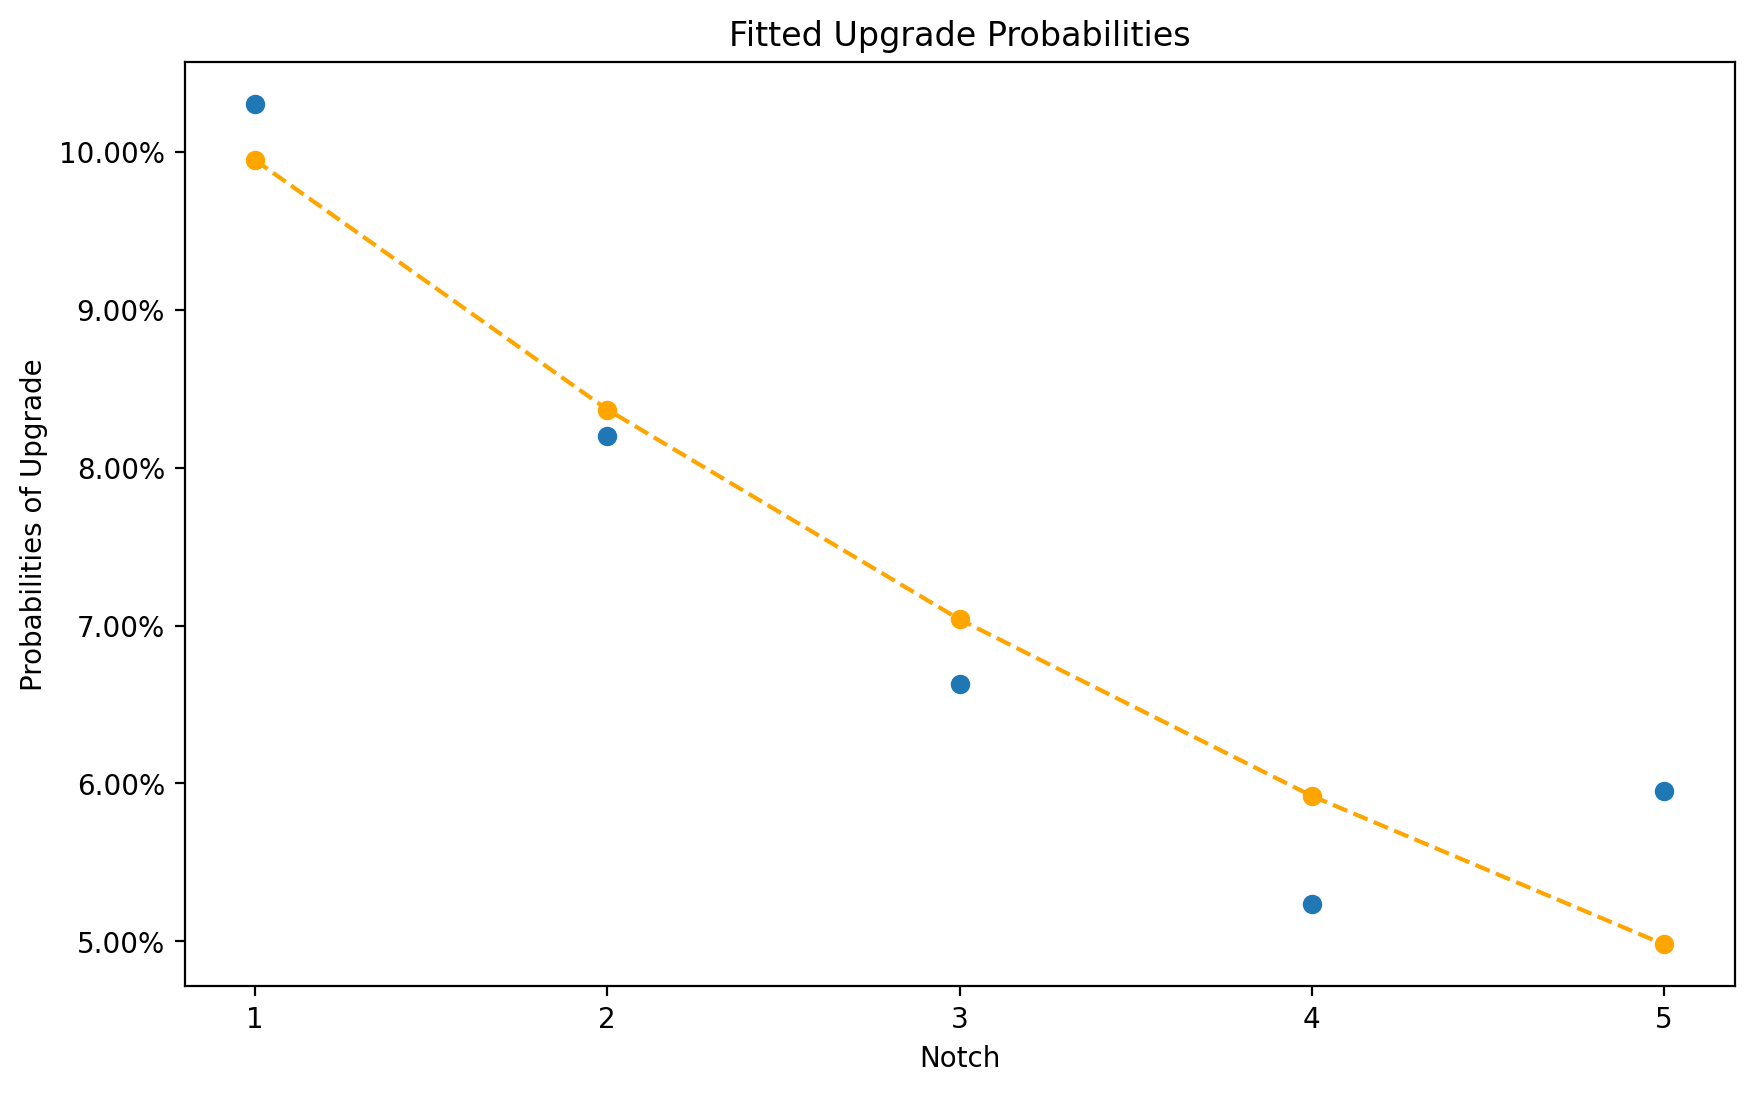

In [12]:
# Result
plotCurve(UpNotch, 'Notch', 'Rate', 'Notch', 'Probabilities of Upgrade', 'Fitted Upgrade Probabilities', function = 'Exponential')

In [13]:
# Downgrade
DownNotch = UpDownWeighted[UpDownWeighted['Notch'] < 0]

# Fitting
popt, _ = curve_fit(
    ExpoDecayFunction,
    abs(DownNotch['Notch']),
    DownNotch['Rate'],
    maxfev = 1000
)

# Assign parameters
Down_p = popt[0]
Down_q = popt[1]

print(f'Downgrade notch change parameters:\np: {Down_p:.4f}\nq: {Down_q:.4f}')

Downgrade notch change parameters:
p: 0.1630
q: -0.1893


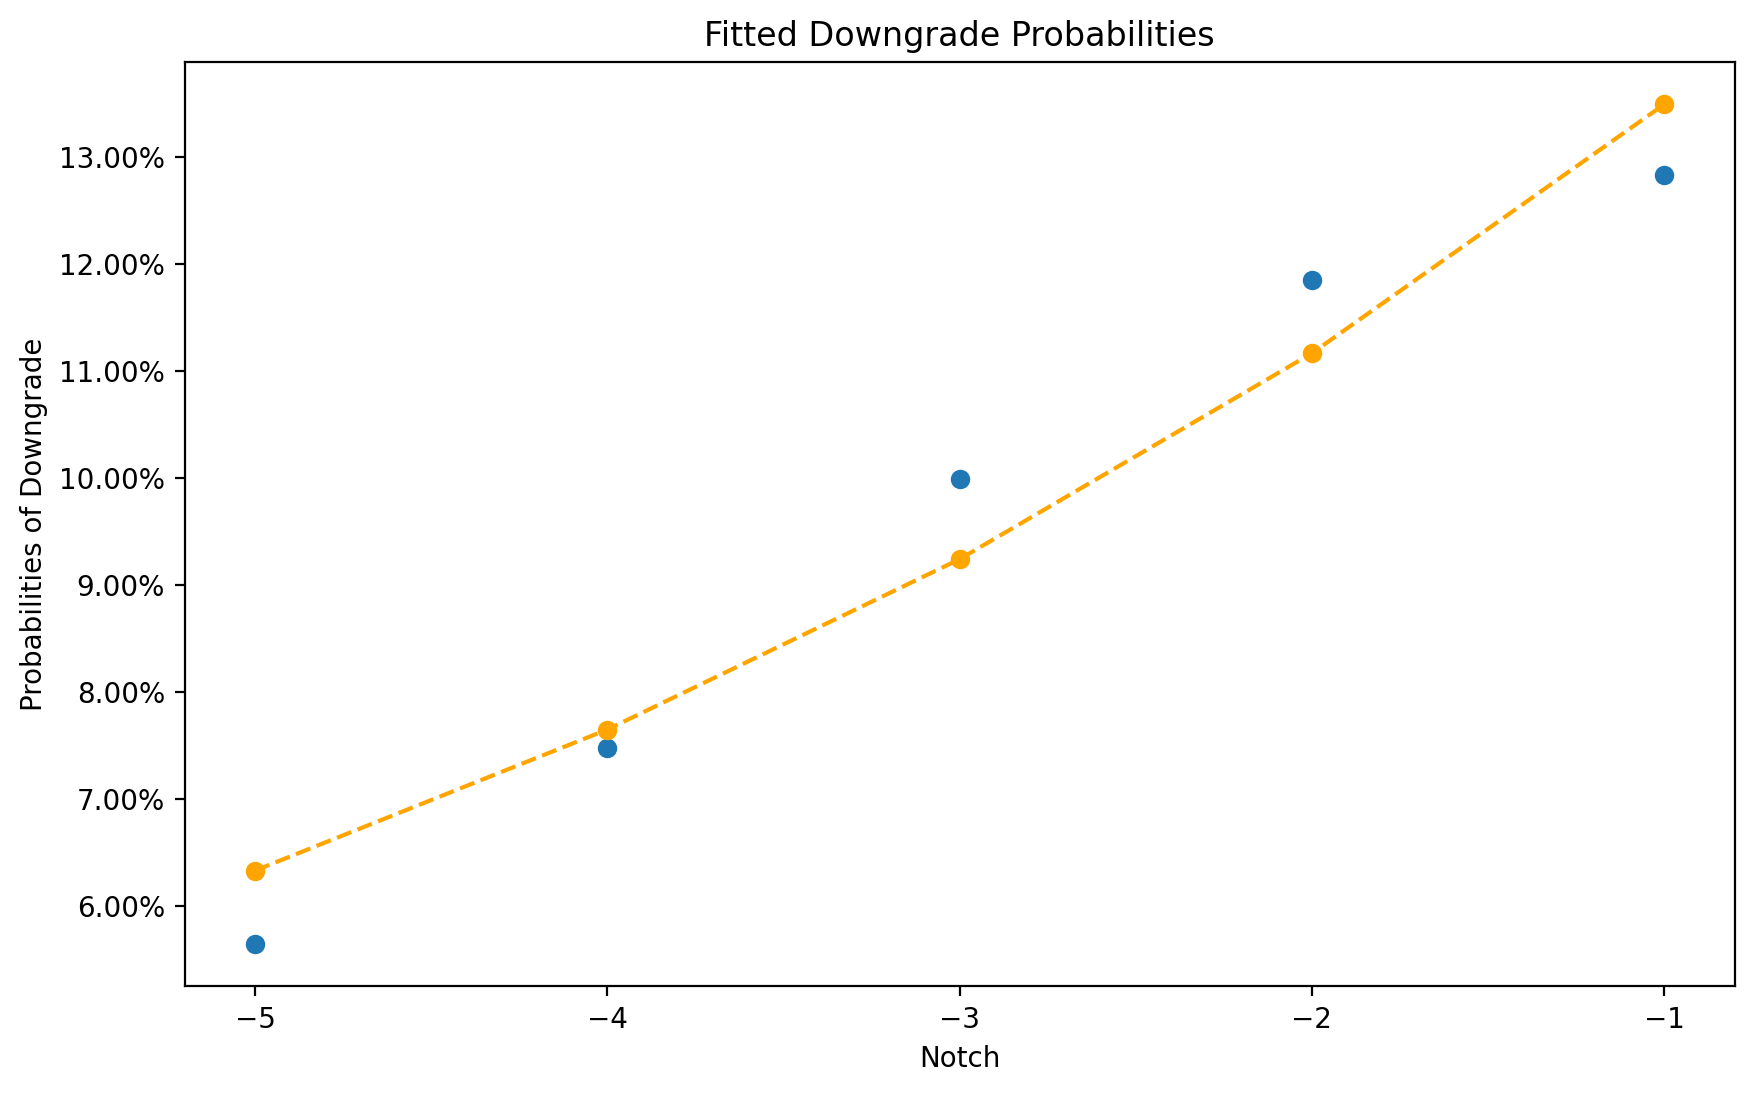

In [14]:
# Result
plotCurve(DownNotch, 'Notch', 'Rate', 'Notch', 'Probabilities of Downgrade', 'Fitted Downgrade Probabilities', function = 'Exponential')

In [15]:
# Upgrade/downgrade by rating
# Upgrade
UpRating = UpDown[UpDown['Notch'] > 0].groupby(
    ['Rating'],
    as_index = False
)['MigrationRate'].sum()

# Show table
UpRating

,Rating,MigrationRate
0,2,0.1158
1,3,0.1599
2,4,0.2166
3,5,0.2999
4,6,0.3933
5,7,0.4246
6,8,0.4305
7,9,0.4114
8,10,0.2869


## Function form for rating on upgrades or downgrades
The function form model to estimate starting rating migration. The rating migration are accumulated by total probability of movement and ensure optimiser can provide minimum error as closely as possible. The quadratic function has been selected for fitting purpose and has been shown below:
\begin{align}
        \text{Rating Movement Rate} = \text{ax}^{2} + {bx} + {c}
    \end{align}

where;
- $a$, $b$ and $c$ are estimated parameters of quadratic function.
- $x$ is rating.

In [16]:
# Fitting with quadratic function
# Define quadratic function
def QuadraticFunction(s, a, b, c):
  return a * s ** 2 + b * s + c

In [17]:
# Fitting
popt, _ = curve_fit(
    QuadraticFunction,
    UpRating['Rating'],
    UpRating['MigrationRate']
)

# Assign parameters
Up_a = popt[0]
Up_b = popt[1]
Up_c = popt[2]

# Result
print(f'Upgrade rating parameters:\na: {Up_a:.4f}\nb: {Up_b:.4f}\nc: {Up_c:.4f}')

Upgrade rating parameters:
a: -0.0109
b: 0.1641
c: -0.2149


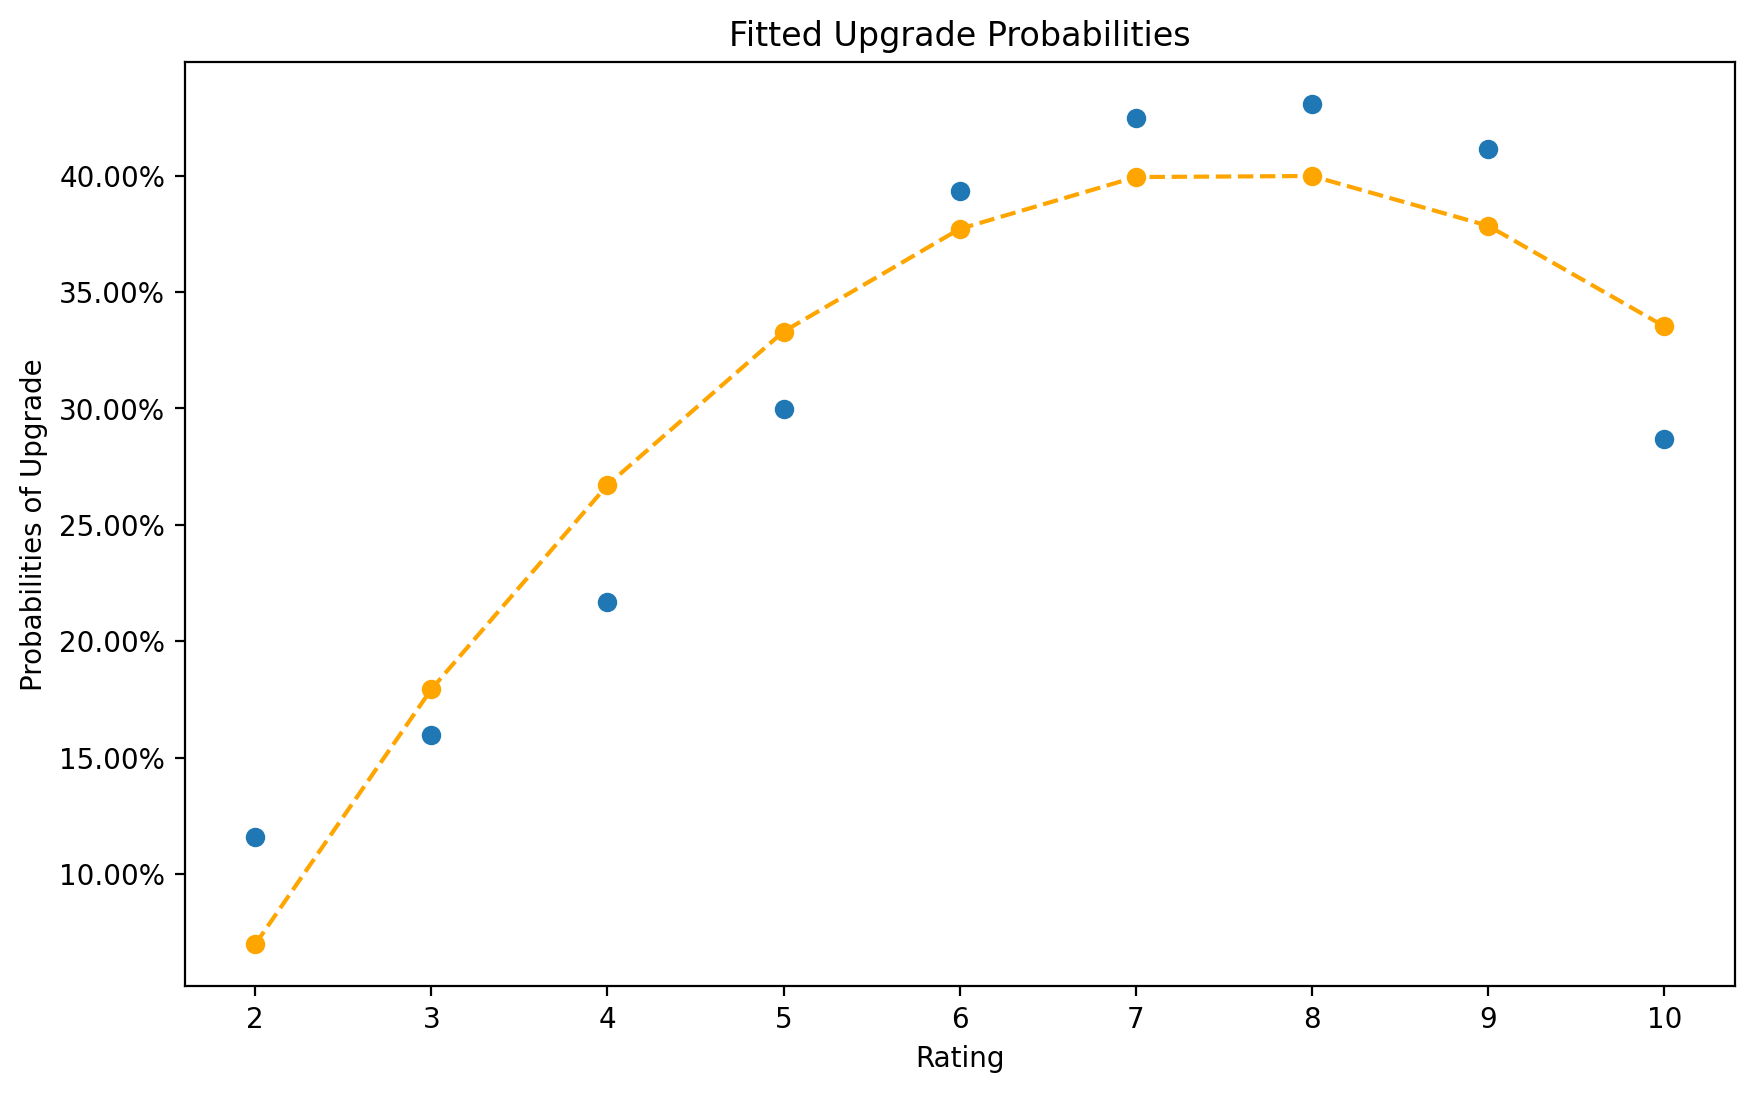

In [18]:
# Result
plotCurve(UpRating, 'Rating', 'MigrationRate', 'Rating', 'Probabilities of Upgrade', 'Fitted Upgrade Probabilities', function = 'Quadratic')

In [19]:
# Downgrade
DownRating = UpDown[UpDown['Notch'] < 0].groupby(
    ['Rating'],
    as_index = False
)['MigrationRate'].sum()

# Show table
DownRating

,Rating,MigrationRate
0,1,0.6210
1,2,0.6719
2,3,0.6305
3,4,0.5379
4,5,0.4131
5,6,0.2964
6,7,0.2000
7,8,0.1543
8,9,0.0621


In [20]:
# Fitting
popt, _ = curve_fit(
    QuadraticFunction,
    DownRating['Rating'],
    DownRating['MigrationRate']
)

# Assign parameters
Down_a = popt[0]
Down_b = popt[1]
Down_c = popt[2]

print(f'Downgrade rating parameters:\na: {Down_a:.4f}\nb: {Down_b:.4f}\nc: {Down_c:.4f}')

Downgrade rating parameters:
a: -0.0045
b: -0.0363
c: 0.7233


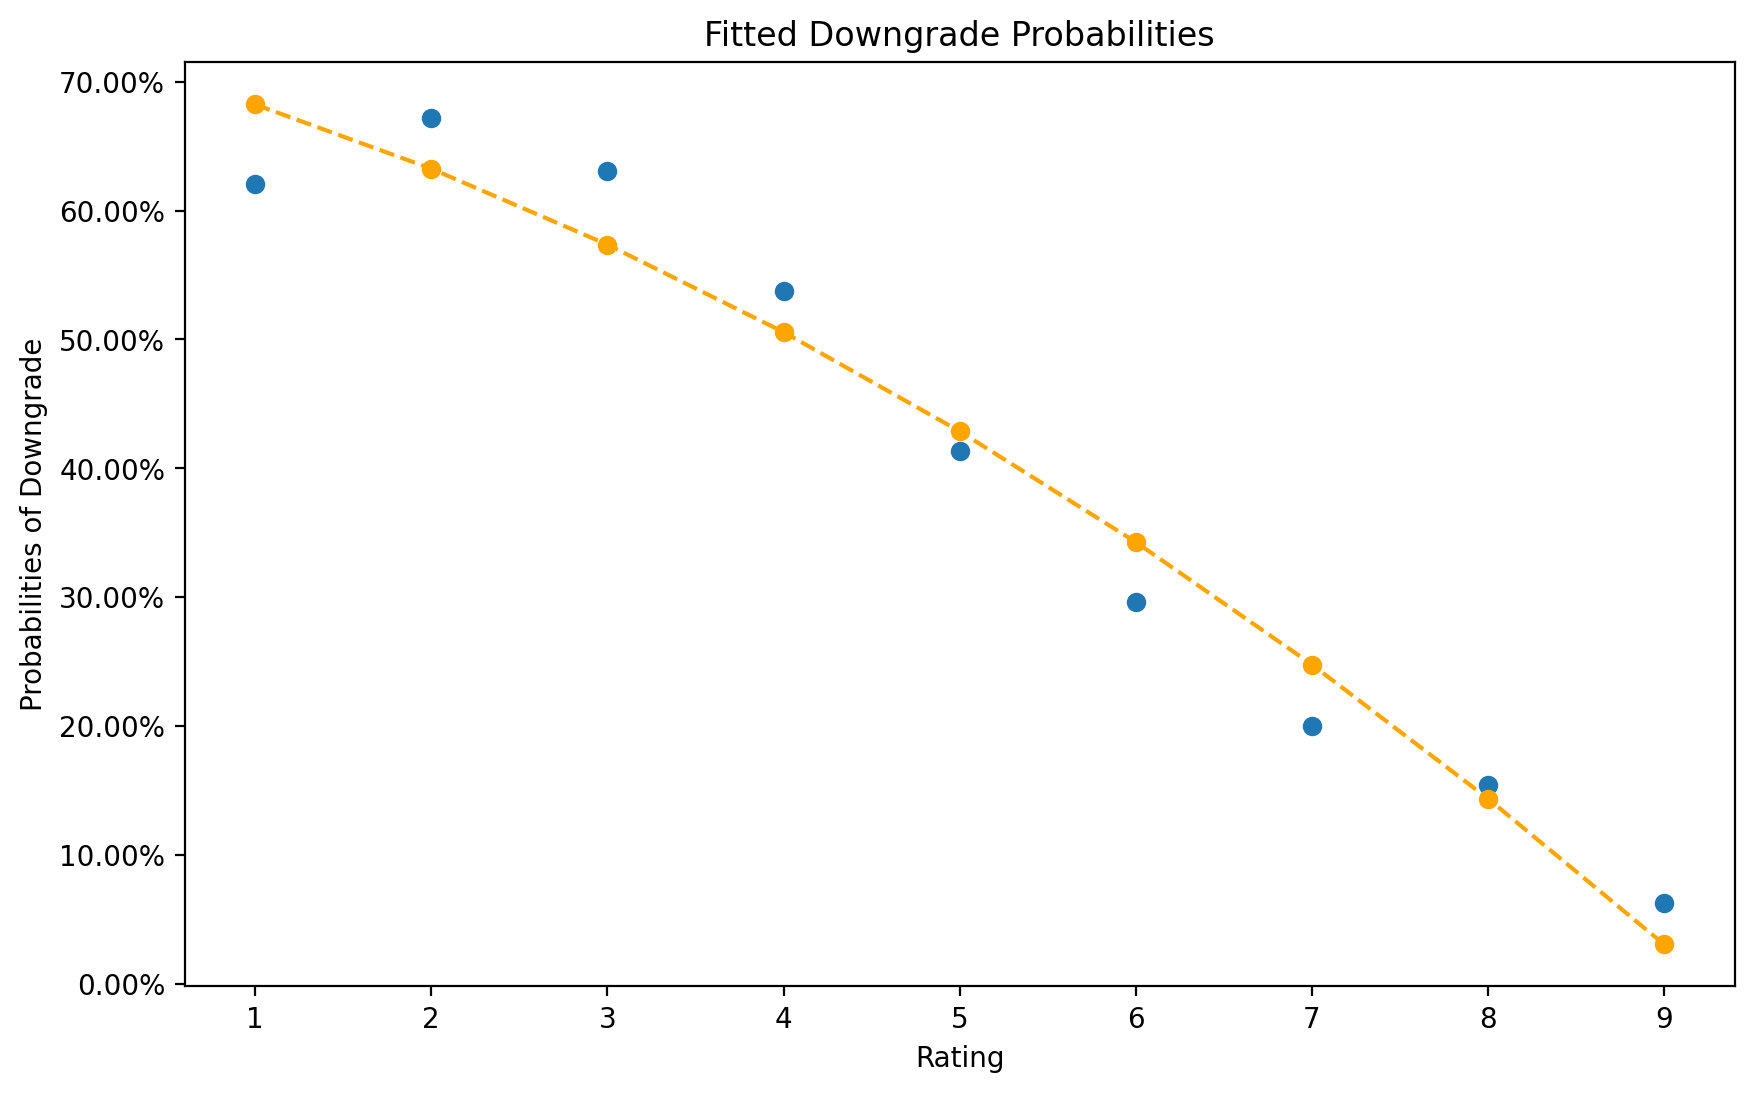

In [21]:
# Result
plotCurve(DownRating, 'Rating', 'MigrationRate', 'Rating', 'Probabilities of Downgrade', 'Fitted Downgrade Probabilities', function = 'Quadratic')

In [22]:
# Calculate distribution for cost function (Error)
Portion = UpDown.groupby(
    ['Rating']
)['TotalCount'].mean()

# To percentage
Portion = Portion.div(
    Portion.sum(),
    axis = 0
)

# Mapping with portion
UpDown['Portion'] = UpDown['Rating'].map(Portion)

# Show table
UpDown.head(5)

,Rating,Rating12,Count,MigrationRate,Notch,TotalCount,Portion
1,1,2,574,0.1295,-1,4396,0.0094
2,1,3,572,0.1290,-2,4396,0.0094
3,1,4,607,0.1369,-3,4396,0.0094
4,1,5,600,0.1353,-4,4396,0.0094
5,1,6,400,0.0902,-5,4396,0.0094


In [23]:
# Seperated tables
# Upgrade
UpDetails = UpDown[UpDown['Notch'] > 0][['Rating', 'Notch', 'MigrationRate', 'Portion']].reset_index(drop = True)
UpDetails['Notch'] = abs(UpDetails['Notch']) #Absolute for notch change

# Show table
UpDetails.head(5)

,Rating,Notch,MigrationRate,Portion
0,2,1,0.1158,0.0685
1,3,2,0.0790,0.1260
2,3,1,0.0808,0.1260
3,4,3,0.0607,0.2387
4,4,2,0.0639,0.2387


In [24]:
# Downgrade
DownDetails = UpDown[UpDown['Notch'] < 0][['Rating', 'Notch', 'MigrationRate', 'Portion']].reset_index(drop = True)
DownDetails['Notch'] = abs(DownDetails['Notch']) #Absolute for notch change

# Show table
DownDetails.head(5)

,Rating,Notch,MigrationRate,Portion
0,1,1,0.1295,0.0094
1,1,2,0.1290,0.0094
2,1,3,0.1369,0.0094
3,1,4,0.1353,0.0094
4,1,5,0.0902,0.0094


## Function form for notches on upgrades or downgrades and rating on upgrades or downgrades
Combination of two functions, which are exponential function and quadratic function produces migration rate of non-diagonal movement. The combined function has been shown below:
\begin{align}
        \text{Migration Rate} = \text{ax}^{2} + {bx} + {c} * [\text{p * e}^{q * n}]
    \end{align}

where;
- $a$, $b$ and $c$ are estimated parameters of quadratic function.
- $p$ and $q$ are estimated parameters of exponential function.
- $n$ is notches chage.
- $x$ is rating.


In [25]:
# Combine 2 functions (exponential decay and quadratic)
# Define function for fitting
def CombineFunctions(x):
  # Upgrade
  UpDetails['Fitted'] = (x[0] * UpDetails['Rating'] ** 2 + x[1] * UpDetails['Rating'] + x[2]) * (x[3] * np.exp(x[4] * UpDetails['Notch']))
  UpDetails.loc[UpDetails['Fitted'] < 0, 'Fitted'] = 0
  UpDetails['Error'] = (UpDetails['MigrationRate'] - UpDetails['Fitted']) ** 2 * UpDetails['Portion']
  # Downgrade
  DownDetails['Fitted'] = (x[5] * DownDetails['Rating'] ** 2 + x[6] * DownDetails['Rating'] + x[7]) * (x[8] * np.exp(x[9] * DownDetails['Notch']))
  DownDetails.loc[DownDetails['Fitted'] < 0, 'Fitted'] = 0
  DownDetails['Error'] = (DownDetails['MigrationRate'] - DownDetails['Fitted']) ** 2 * DownDetails['Portion']
  # Target error
  ParametersUp = sum(
      (
          np.abs(Up_a - x[0]),
          np.abs(Up_b - x[1]),
          np.abs(Up_c - x[2]),
          np.abs(Up_p - x[3]),
          np.abs(Up_q - x[4])
      )
  )
  ParametersDown = sum(
      (
          np.abs(Down_a - x[5]),
          np.abs(Down_b - x[6]),
          np.abs(Down_c - x[7]),
          np.abs(Down_p - x[8]),
          np.abs(Down_q - x[9])
      )
  )
  TotalError = np.sum(UpDetails['Error']) + np.sum(DownDetails['Error']) + ParametersUp + ParametersDown
  return TotalError

In [26]:
# Initial guess
x0 = 0.001 * np.ones(10)

# Solver
SolvedParameters = minimize(
    CombineFunctions,
    x0,
    method = 'SLSQP',
)

In [27]:
# Result
SolvedParameters.x

array([-0.00971497,  0.16414299, -0.21493919,  0.11825304, -0.17293564,
       -0.00426291, -0.03631892,  0.72330661,  0.16300396, -0.18928523])

In [28]:
# Assign parameters
# Upgrade
EstUp_a = SolvedParameters.x[0]
EstUp_b = SolvedParameters.x[1]
EstUp_c = SolvedParameters.x[2]
EstUp_p = SolvedParameters.x[3]
EstUp_q = SolvedParameters.x[4]

# Downgrade
EstDown_a = SolvedParameters.x[5]
EstDown_b = SolvedParameters.x[6]
EstDown_c = SolvedParameters.x[7]
EstDown_p = SolvedParameters.x[8]
EstDown_q = SolvedParameters.x[9]

In [29]:
# Fitted to migration matrix
FittedMatrix = RAW_COUNT[
    (RAW_COUNT['Rating'] != DEFAULT_INDEX) & (RAW_COUNT['Rating12'] != DEFAULT_INDEX)
] #Excluded default for another model

# Notch change
FittedMatrix['Notch'] = FittedMatrix['Rating'] - FittedMatrix['Rating12']
FittedMatrix['Notch'] = abs(FittedMatrix['Notch']) #Taking absolute for calculation

# Show table
FittedMatrix.head(5)

,Rating,Rating12,Count,MigrationRate,Notch
0,1,1,1075,0.2425,0
1,1,2,574,0.1295,1
2,1,3,572,0.1290,2
3,1,4,607,0.1369,3
4,1,5,600,0.1353,4


In [30]:
# Fitted migration rate
FittedMatrix['EstimatedMigration'] = np.where(
    (FittedMatrix['Rating'] == FittedMatrix['Rating12']), #Stay condition
    np.nan,
    np.where(
        (FittedMatrix['Rating'] > FittedMatrix['Rating12']), #Upgrade condition
        (EstUp_a * FittedMatrix['Rating'] ** 2 + EstUp_b * FittedMatrix['Rating'] + EstUp_c) * (EstUp_p * np.exp(EstUp_q * FittedMatrix['Notch'])),
        (EstDown_a * FittedMatrix['Rating'] ** 2 + EstDown_b * FittedMatrix['Rating'] + EstDown_c) * (EstDown_p * np.exp(EstDown_q * FittedMatrix['Notch'])) #Else for downgrade
    )
)

# Show table
FittedMatrix.head(5)

,Rating,Rating12,Count,MigrationRate,Notch,EstimatedMigration
0,1,1,1075,0.2425,0,NaN
1,1,2,574,0.1295,1,0.0921
2,1,3,572,0.1290,2,0.0762
3,1,4,607,0.1369,3,0.0631
4,1,5,600,0.1353,4,0.0522


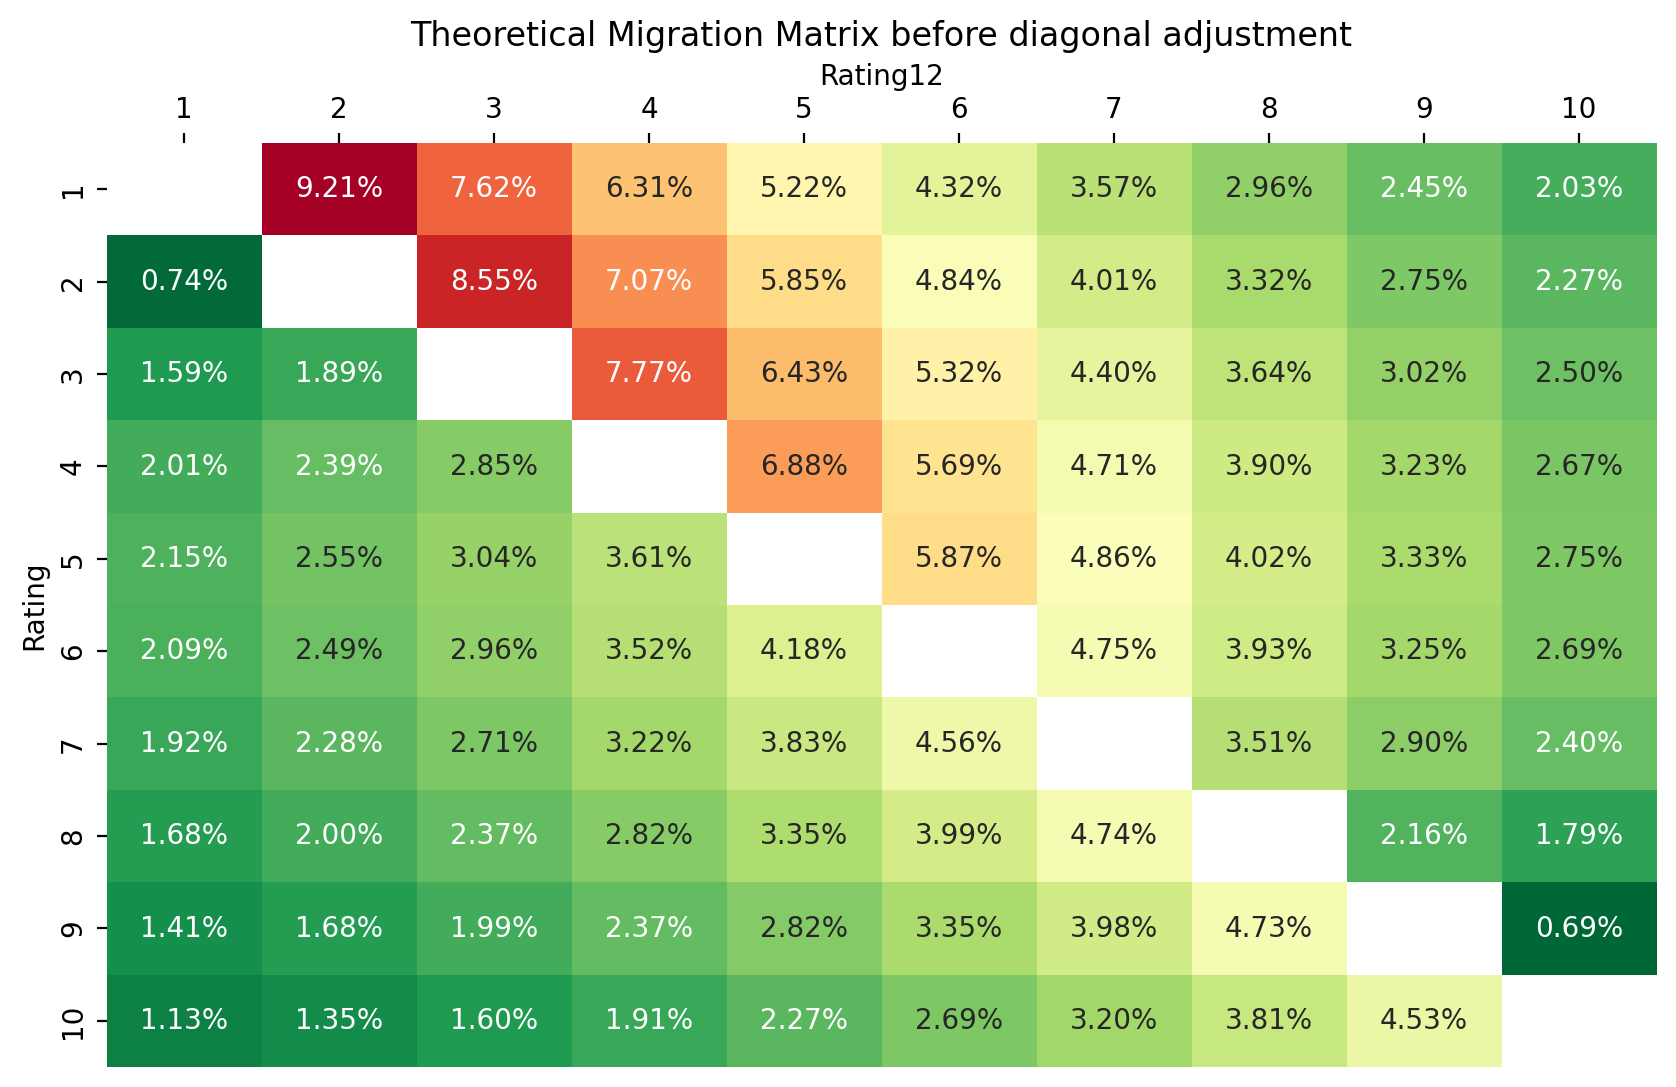

In [31]:
# To migration matrix
TMM = pd.pivot_table(
    FittedMatrix,
    values = 'EstimatedMigration',
    index = ['Rating'],
    columns = ['Rating12']
)

# Show matrix
plotMatrix(TMM, 'Theoretical Migration Matrix before diagonal adjustment', 'Percent')

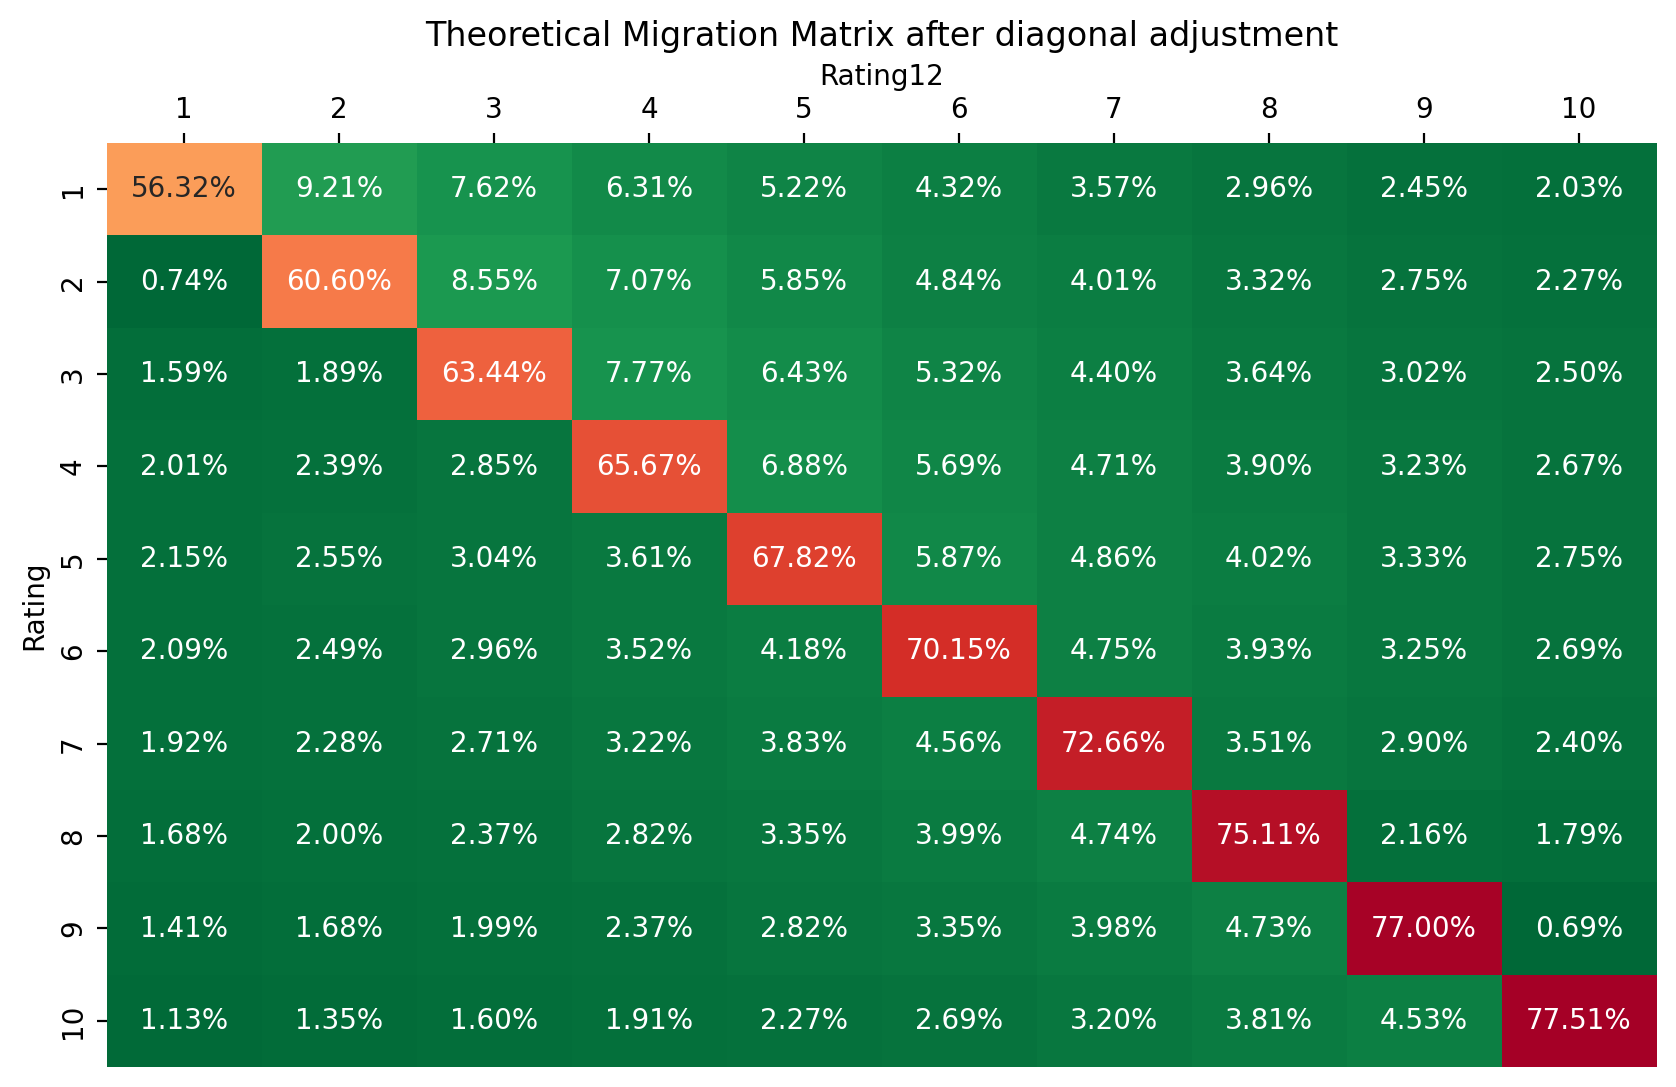

In [32]:
# Diagonal adjustment
TMM = TMM.fillna(1 - TMM.sum(axis = 1)) #Sum = 100%

# Show matrix
plotMatrix(TMM, 'Theoretical Migration Matrix after diagonal adjustment', 'Percent')

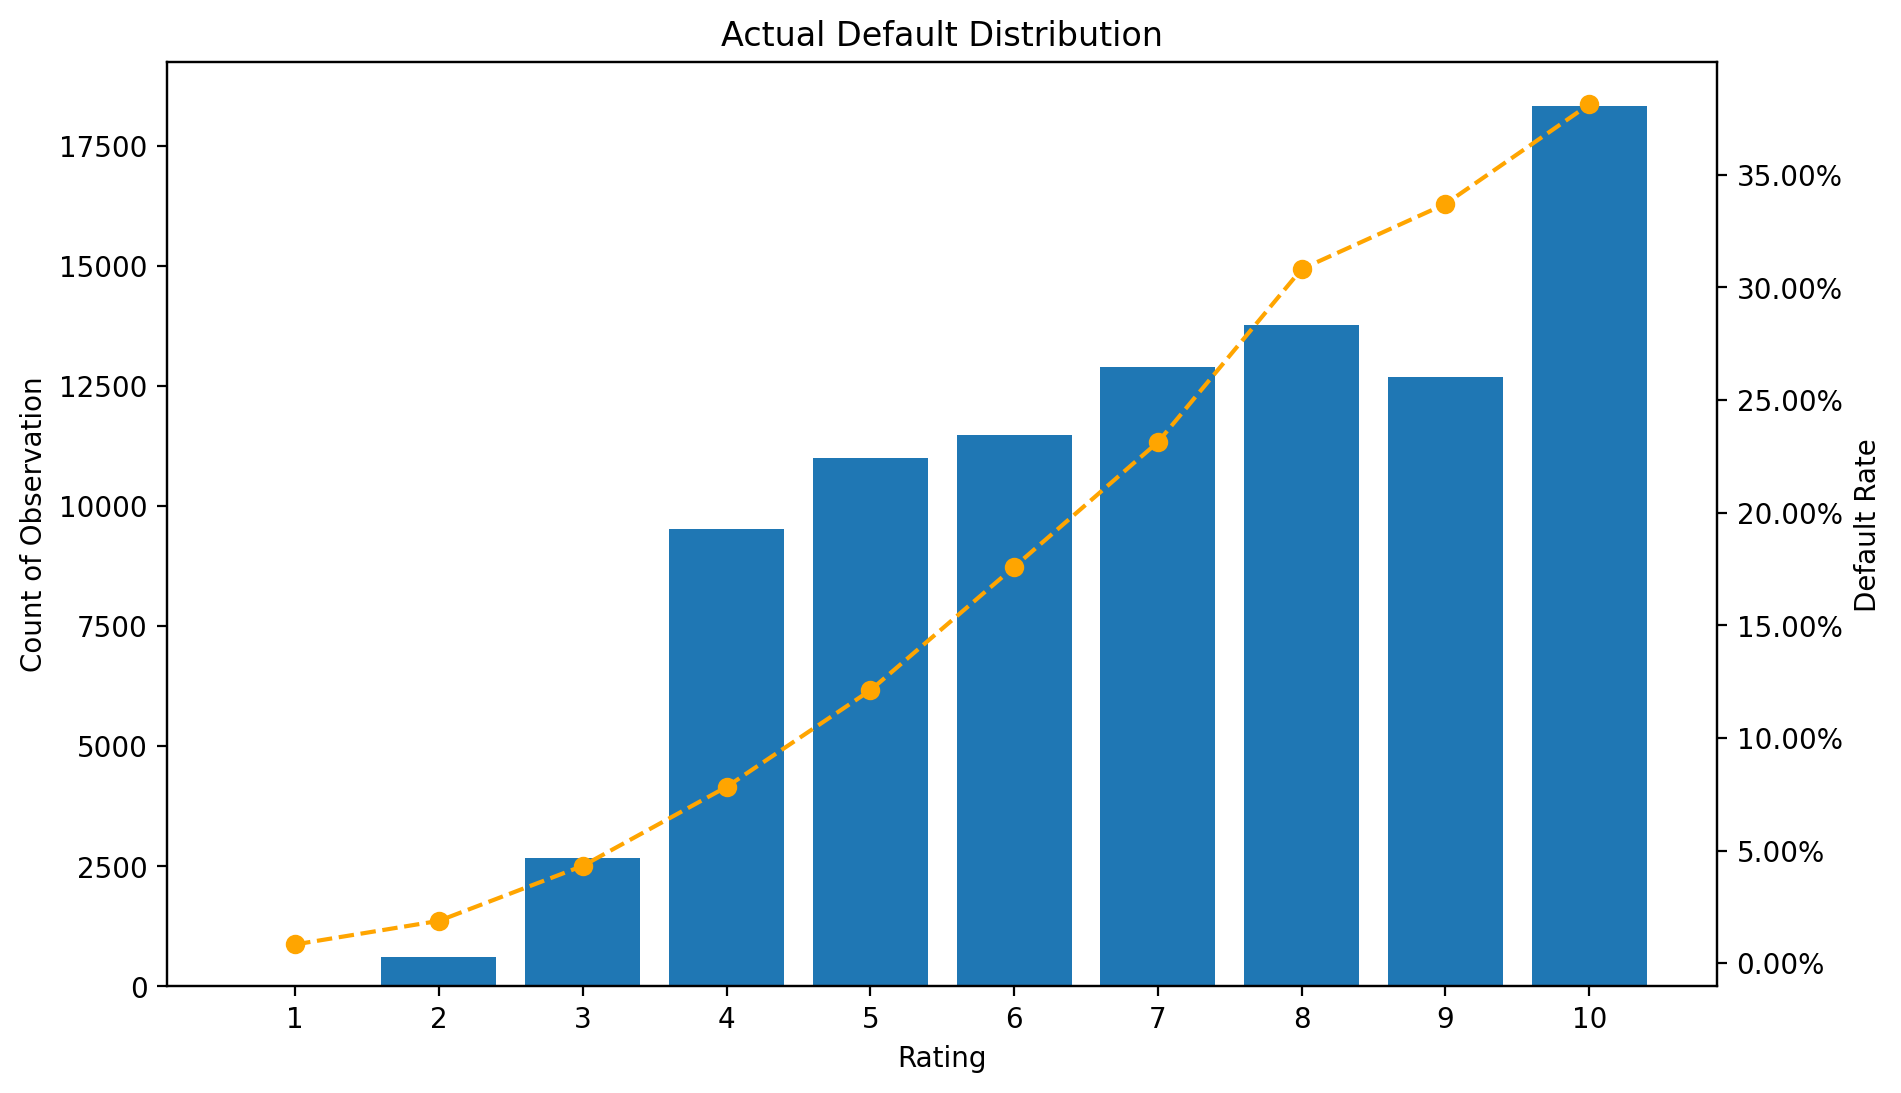

In [33]:
# Default rate
DefaultRate = RAW_COUNT[
    (RAW_COUNT['Rating'] != DEFAULT_INDEX) & (RAW_COUNT['Rating12'] == DEFAULT_INDEX)
].reset_index(drop = True) #Without existing default

# Re-index
DefaultRate.index = DefaultRate.index + 1 #Equal to rating

# Plot
plotRate(DefaultRate, 'Rating', 'Count', 'MigrationRate', 'Rating', 'Count of Observation', 'Default Rate', 'Actual Default Distribution')

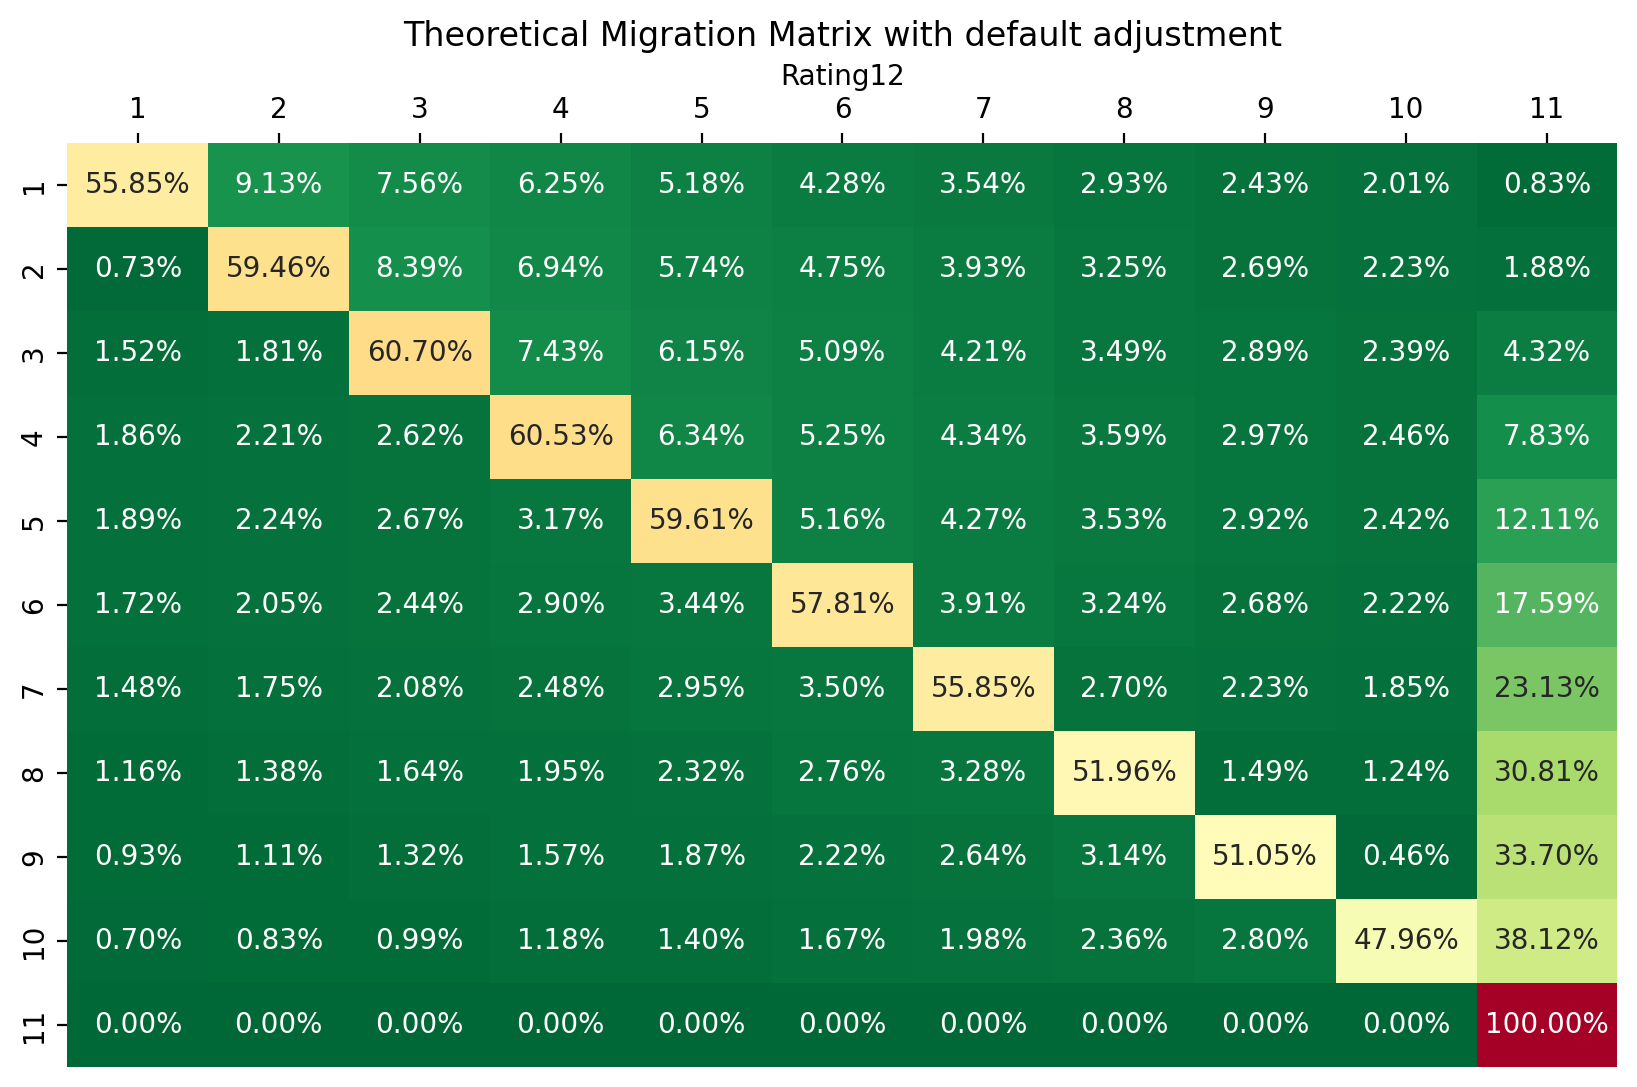

In [34]:
# Adjust with default rate in TMM
TMMAdj = TMM.mul(
    1 - DefaultRate['MigrationRate'],
    axis = 0
)
TMMAdj[11] = TMMAdj.index.map(DefaultRate['MigrationRate']) #Replace with default rate


TMMAdj = pd.concat(
    [
        TMMAdj,
        pd.DataFrame(
            [[0] * TMMAdj.shape[1]],
            columns = TMMAdj.columns
        )
    ],
    ignore_index = True
) #Add default row
TMMAdj.index = TMMAdj.index + 1 #Re-index
TMMAdj.iloc[10, 10] = 1 #Ever default row

# Show matrix
plotMatrix(TMMAdj, 'Theoretical Migration Matrix with default adjustment', 'Percent')

In [35]:
# TMM Liftetime
# 10 Years cumulative PD
TMMLifetime = [np.array(TMMAdj.iloc[:,-1])]
for i in range(10):
  TMMLifetime.append(np.dot(TMMAdj, TMMLifetime[i]))

TMMLifetime = pd.DataFrame(TMMLifetime).T
TMMLifetime['Rating'] = TMMLifetime.index + 1

In [36]:
# Actual Liftetime
# 10 Years cumulative PD
ActualLifetime = [np.array(RawMatrix.iloc[:,-1])]
for i in range(10):
  ActualLifetime.append(np.dot(RawMatrix, ActualLifetime[i]))

ActualLifetime = pd.DataFrame(ActualLifetime).T
ActualLifetime['Rating'] = ActualLifetime.index + 1

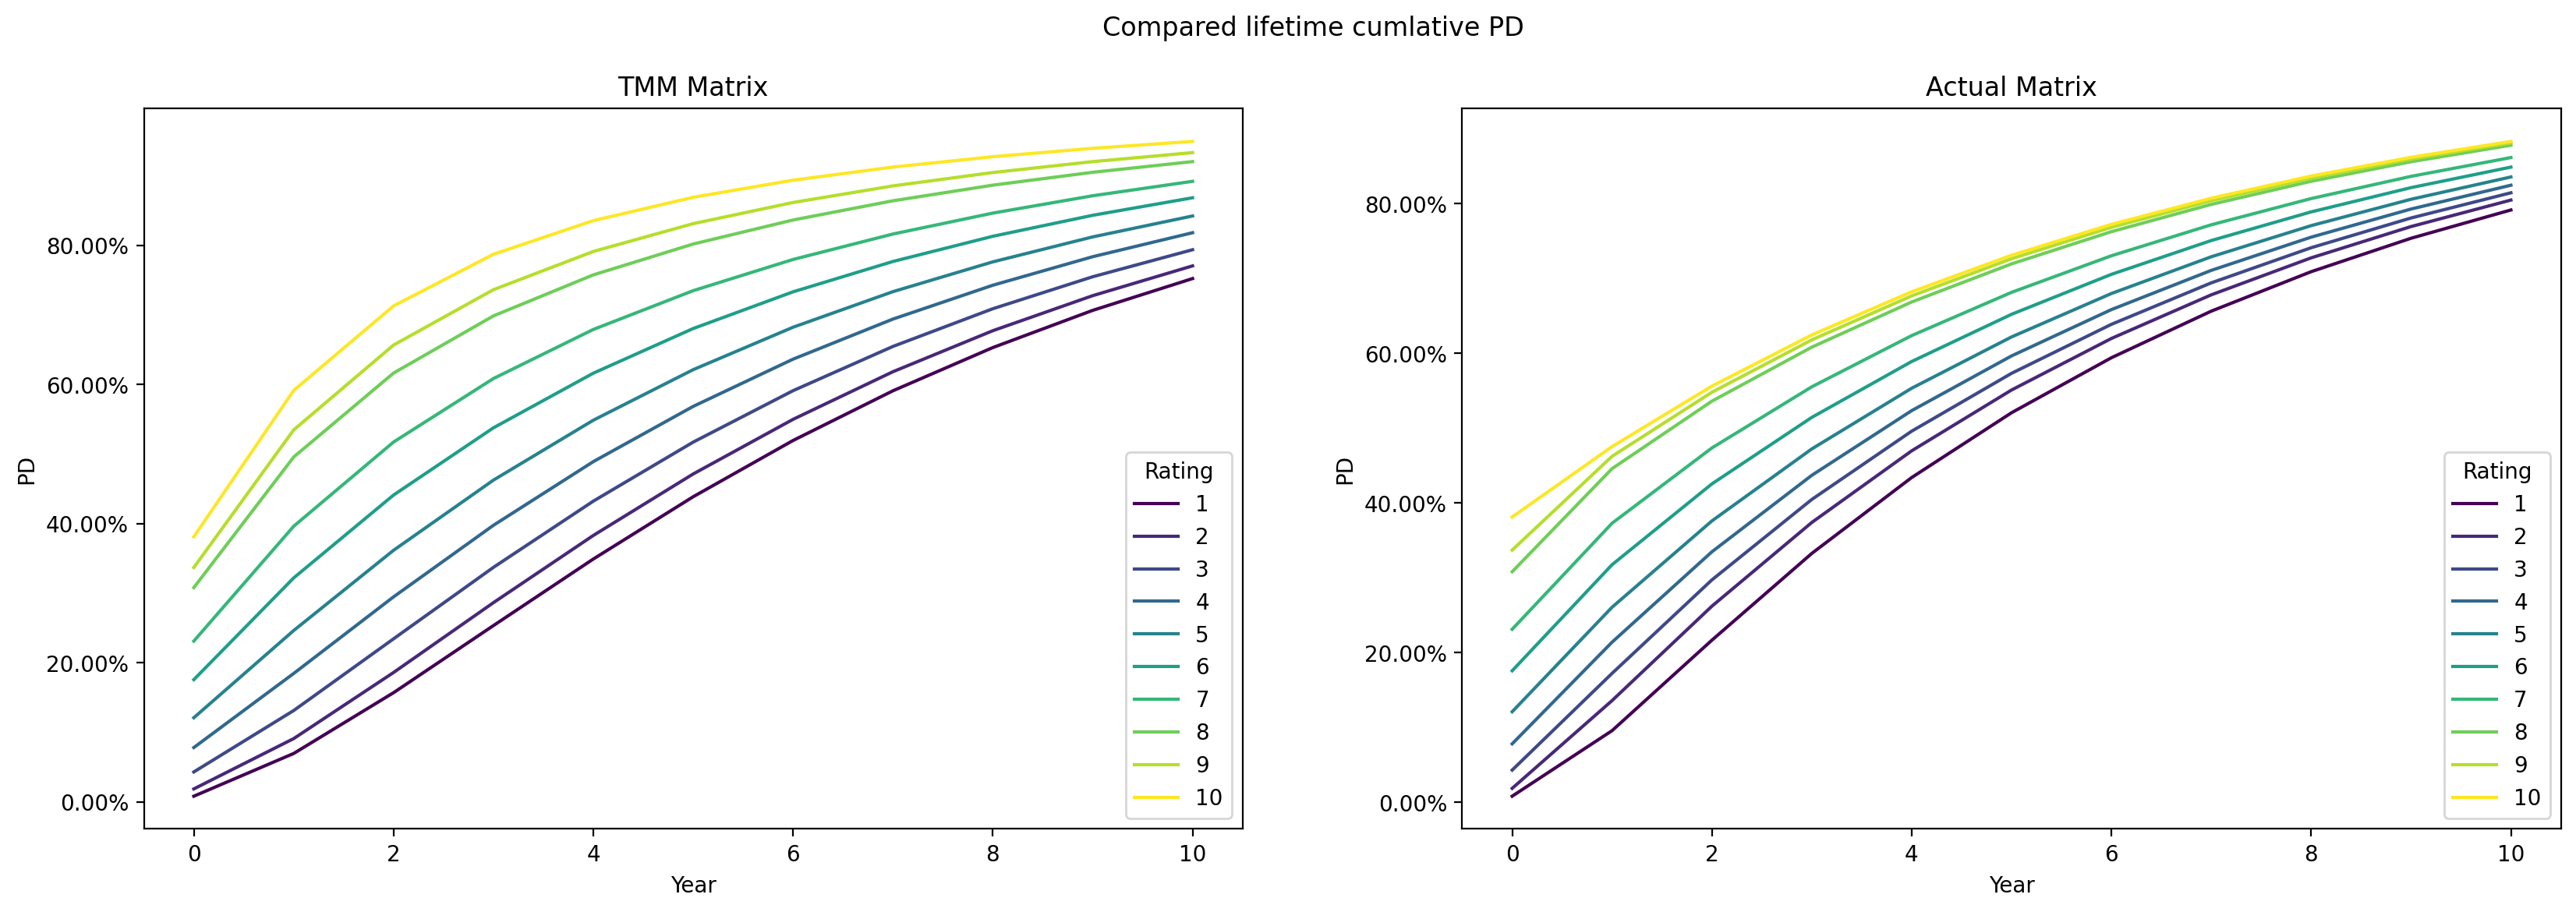

In [37]:
# Plot
fig, axs = plt.subplots(1, 2, figsize = (20, 6))
fig.suptitle('Compared lifetime cumlative PD')
axs = axs.ravel()
sns.lineplot(
    x = 'Year',
    y = 'PD',
    data = pd.melt(
        TMMLifetime.iloc[:-1,:],
        id_vars = ['Rating'],
        var_name = 'Year',
        value_name = 'PD').sort_values(
    by = ['Rating', 'Year']
    ),
    hue = 'Rating',
    legend = 'full',
    palette = 'viridis',
    ci = None,
    ax = axs[0]
)
axs[0].set_title('TMM Matrix')
axs[0].yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100))
)
sns.lineplot(
    x = 'Year',
    y = 'PD',
    data = pd.melt(
        ActualLifetime.iloc[:-1,:],
        id_vars = ['Rating'],
        var_name = 'Year',
        value_name = 'PD').sort_values(
    by = ['Rating', 'Year']
    ),
    hue = 'Rating',
    legend = 'full',
    palette = 'viridis',
    ci = None,
    ax = axs[1]
)
axs[1].set_title('Actual Matrix')
axs[1].yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100))
)
plt.show()